<a href="https://colab.research.google.com/github/sandhyaparna/NLP/blob/main/Take%20Home%20Assignments/Dell_Take_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load tweets, replacements dictionary and important features files

In [1]:
from google.colab import files

print("upload boston_bombing_tweets - Home test Data Scientist.csv file")
tweets_uploaded = files.upload()

upload boston_bombing_tweets - Home test Data Scientist.csv file


Saving boston_bombing_tweets - Home test Data Scientist.csv to boston_bombing_tweets - Home test Data Scientist.csv


In [2]:
print("upload replacements_dict.json file")
dict_uploaded = files.upload()

upload replacements_dict.json file


Saving replacements_dict.json to replacements_dict.json


In [3]:
print("upload important_features_ngrams.txt file")
imp_features_uploaded = files.upload()

upload important_features_ngrams.txt file


In [4]:
# import Libraries
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json, pickle, string, re, os, io
import collections 
from collections import defaultdict, Counter, OrderedDict

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['i']
stop_words = stop_words + more_stopwords

import spacy
nlp = spacy.load('en', parse = False, tag=False, entity=False)

from wordcloud import WordCloud
import textblob
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
boston_bombing_tweets = pd.read_csv(io.BytesIO(tweets_uploaded['boston_bombing_tweets - Home test Data Scientist.csv']))
print(f'Tweets data is loaded')

tweets_train = boston_bombing_tweets[pd.notnull(boston_bombing_tweets.label)]
print("Number of observations in train data are", tweets_train.shape[0])

tweets_test = boston_bombing_tweets[pd.isnull(boston_bombing_tweets.label)]
print("Number of observations in test data are", tweets_test.shape[0])

Tweets data is loaded
Number of observations in train data are 4000
Number of observations in test data are 12218


In [6]:
# load replacements_dict
with open('replacements_dict.json') as json_file:
  replacements_dict = json_file.readlines()
  
replacements_dict = map(lambda x: x.rstrip(), replacements_dict)
replacements_dict = ' '.join(replacements_dict)
replacements_dict = json.loads(replacements_dict, object_pairs_hook=OrderedDict)
print("replacements dictionary is loaded")

replacements dictionary is loaded


In [8]:
# load important_features_ngrams
important_features_ngrams = []

with open('important_features_ngrams.txt', 'r') as filehandle:
    for line in filehandle:
        feature = line[:-1]
        important_features_ngrams.append(feature)
print("important_features_ngrams is loaded")

FileNotFoundError: ignored

In [9]:
# helper functions
def replace_all(text, dic=replacements_dict):
    for i, j in dic.items():
        text = re.sub(i, j, text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
    
def text_preprocess(text):
  text = re.sub('[%s]' % re.escape(string.punctuation.replace('#','')), '', text)
  text = re.sub('^# |# ', '', text)
  text = re.sub('[^\u0000-\u007e]+', '', text)
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  return text

def create_corpus(data, text_var, condition):
    corpus=[]
    
    if condition == "hash":
      for x in data['text_processed'].apply(lambda x: re.findall(r'(?<=)#\w+',x)):
          for i in x:
            corpus.append(i)
    
    else:  # non-hash words
      for x in data['text_processed'].apply(lambda x: re.findall(r'(?#)\w+',x)):
        for i in x:
          corpus.append(i)

    return corpus

def get_top_tweet_ngrams(corpus, n):
    vec = CountVectorizer(ngram_range=(n, n), token_pattern=r'\b\w\w+\b|(?<!\w)#\w+').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:None]

In [10]:
# pre-processing function
def preprocessing_fn(data, text_var):
  """
  delete missing values, 

  """
  data = data[pd.notnull(data[text_var])]
  data[text_var+'_processed'] = data[text_var].str.lower()
  data[text_var+'_URL_present'] = np.where(data[text_var+'_processed'].str.contains("http://"),1,0)
  data[text_var+'_retweet'] = np.where(data[text_var+'_processed'].str.contains("rt @"),1, 0)

  data[text_var+'_processed'] = data[text_var+'_processed'].apply(lambda x: replace_all(x,replacements_dict))
  data[text_var+'_punctuations_count'] = data[text_var+'_processed'].apply(lambda x: re.findall('[%s]' % re.escape(string.punctuation),str(x))).str.len() 
  data[text_var+'_word_count'] = data[text_var+'_processed'].apply(lambda x: len(str(x).split()))
  data[text_var+'_hashtag_count'] = data[text_var+'_processed'].apply(lambda x: len([c for c in str(x) if c == '#']))
  
  data[text_var+'_processed'] = data[text_var+'_processed'].apply(lambda x: lemmatize_text(x))
  data[text_var+'_processed'] = data[text_var+'_processed'].apply(lambda x: text_preprocess(x))

  return data

### Baseline Model

In [11]:
# feature engineering of n-grams
def feature_engineering(data):
  features = []

  for i, j in Counter(create_corpus(data, "text_processed", "non-hash")).items():
    if j > 30:
      features.append(i)

  for i, j in Counter(create_corpus(data, "text_processed", "hash")).items():
    if j > 10:
      features.append(i)

  for i, j in get_top_tweet_ngrams(data["text_processed"], 2):
    if j > 10:
      features.append(i)

  for i, j in get_top_tweet_ngrams(data["text_processed"], 3):
    if j > 5:
      features.append(i)

  print(features)
  print(len(features))

  for i in features:
    data[i] = np.where(data["text_processed"].str.contains(i),1,0)  # data[i+"_ngram"]
  
  # data.columns = data.columns.str.replace(' ', '_')
  
  return data

In [12]:
# model building
def build_model(data):
  
  data = data.drop(['text', 'text_processed'],axis=1)

  # split data into 80% Train & 20% Test - Stratified split
  X = data.drop(['label'],axis=1)
  y = data[['label']]
  X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.20, random_state=42)
  
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  # create model
  nb = MultinomialNB()
  # evaluate model
  scores = cross_val_score(nb, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report performance
  print('Cross Validation Accuracy Score: %.3f (%.3f)\n' % (np.mean(scores), np.std(scores)))

  # train the model
  nb.fit(X_train, y_train)

  # make class and probability predictions
  y_pred_class = nb.predict(X_eval)
  y_pred_prob = nb.predict_proba(X_eval)[:, 1]

  print("Performance evaluation of the Naive Bayes model")

  print("Confusion Matrix","\n",pd.crosstab(y_eval.label, y_pred_class, rownames=['True'], colnames=['Predicted'], margins=True))

  print("\n","Classification Report","\n",classification_report(y_eval, y_pred_class))

  fpr, tpr, thresholds = roc_curve(y_eval, y_pred_prob)
  # create plot
  plt.plot(fpr, tpr, label='ROC curve'+', AUC='+str(round(roc_auc_score(y_eval, y_pred_prob).mean(),3)))
  plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
  _ = plt.xlabel('False Positive Rate')
  _ = plt.ylabel('True Positive Rate')
  _ = plt.title('ROC Curve')
  _ = plt.xlim([-0.02, 1])
  _ = plt.ylim([0, 1.02])
  _ = plt.legend(loc="lower right")

  return nb, plt

['report', 'suspect', 'custody', 'man', 'terrorist', 'still', 'boat', 'dzhokhar', 'tsarnaev', 'terror', 'president', 'street', 'watertown', 'boston', 'old', 'day', 'one', 'win', 'look', 'job', 'cambridge', 'bomb', 'attack', 'let', 'us', 'make', 'great', 'thing', 'like', 'bostonstrong', 'never', 'find', 'give', 'heart', 'get', 'time', 'want', 'dead', 'marathon', 'bombing', 'start', 'prayforboston', 'happen', 'prayer', 'go', 'family', 'come', 'tonight', 'back', 'good', 'first', 'place', 'new', 'run', 'event', 'even', 'police', 'everyone', 'today', 'city', 'home', 'life', 'tamerlan', 'via', 'pray', 'world', 'bostonmarathon', 'service', 'assistant', 'area', 'week', 'work', 'software', 'manager', 'two', 'see', 'team', 'help', 'w', 'friend', 'update', 'manhunt', 'think', 'would', 'l', 'celtic', 'ticket', 'snow', 'tomorrow', 'year', 'love', 'high', 'full', 'right', 'talk', 'use', 'house', 'know', 'victim', 'please', 'many', 'take', 'live', 'redsox', 'official', 'say', 'brother', 'game', 'engi

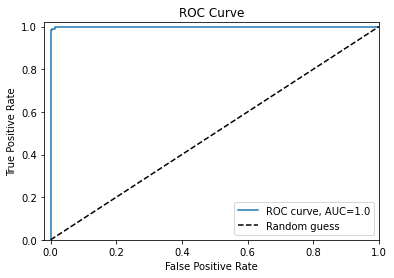

In [13]:
model, model_results = build_model(feature_engineering(preprocessing_fn(tweets_train, "text")))

### Model with only important features

In [14]:
def imp_features(model, data_X, data_y):
  imps = permutation_importance(model, data_X, data_y)
  importances = imps.importances_mean
  indices = np.argsort(importances)[::-1]
  independent_cols = list(data_X)
  important_features = []
  for f in range(data_X.shape[1]):
    if importances[indices[f]] > 0: 
      important_features.append(independent_cols[indices[f]])
  return important_features

In [15]:
tweets_processed = feature_engineering(preprocessing_fn(tweets_train, "text"))

# split data into 80% Train & 20% Test - Stratified split
X = tweets_processed.drop(['label', 'text', 'text_processed'],axis=1)
y = tweets_processed[['label']]
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.20, random_state=42)

# model
nb = MultinomialNB()
# train the model
nb.fit(X_train, y_train)

important_features_ngrams = set(imp_features(nb, X, y)+imp_features(nb, X_eval, y_eval))

with open('important_features_ngrams.txt', 'w') as filehandle:
    for feature in important_features_ngrams:
        filehandle.write('%s\n' % feature)

['report', 'suspect', 'custody', 'man', 'terrorist', 'still', 'boat', 'dzhokhar', 'tsarnaev', 'terror', 'president', 'street', 'watertown', 'boston', 'old', 'day', 'one', 'win', 'look', 'job', 'cambridge', 'bomb', 'attack', 'let', 'us', 'make', 'great', 'thing', 'like', 'bostonstrong', 'never', 'find', 'give', 'heart', 'get', 'time', 'want', 'dead', 'marathon', 'bombing', 'start', 'prayforboston', 'happen', 'prayer', 'go', 'family', 'come', 'tonight', 'back', 'good', 'first', 'place', 'new', 'run', 'event', 'even', 'police', 'everyone', 'today', 'city', 'home', 'life', 'tamerlan', 'via', 'pray', 'world', 'bostonmarathon', 'service', 'assistant', 'area', 'week', 'work', 'software', 'manager', 'two', 'see', 'team', 'help', 'w', 'friend', 'update', 'manhunt', 'think', 'would', 'l', 'celtic', 'ticket', 'snow', 'tomorrow', 'year', 'love', 'high', 'full', 'right', 'talk', 'use', 'house', 'know', 'victim', 'please', 'many', 'take', 'live', 'redsox', 'official', 'say', 'brother', 'game', 'engi

In [16]:
# imp = []
# for i in important_features:
#   i = i.replace("_ngram", "")
#   i = i.replace("_", " ")
#   imp.append(i)
# imp

In [17]:
def feature_engineering_imp(data, important_features):

  for i in important_features:
    data[i] = np.where(data["text_processed"].str.contains(i),1,0)
  
  return data

Cross Validation Accuracy Score: 0.988 (0.006)

Performance evaluation of the Naive Bayes model
Confusion Matrix 
 Predicted  0.0  1.0  All
True                    
0.0        397    6  403
1.0          0  397  397
All        397  403  800

 Classification Report 
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       403
         1.0       0.99      1.00      0.99       397

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



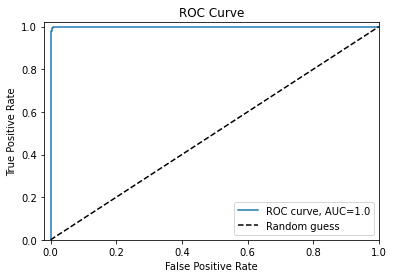

In [18]:
model_imp_features, model_results_imp_features = build_model(feature_engineering_imp(preprocessing_fn(tweets_train, "text"), important_features_ngrams))

In [19]:
# save model 
filename = 'boston_bombing_tweets_model.sav'
pickle.dump(model_imp_features, open(filename, 'wb'))

### TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
TFIDFNGrams_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=100)
X = TFIDFNGrams_vectorizer.fit_transform(tweets_processed.text_processed.values)
TextDf_TFIDFNGramsVectors = pd.DataFrame(X.A, columns=TFIDFNGrams_vectorizer.get_feature_names())
print(TextDf_TFIDFNGramsVectors.shape)
TextDf_TFIDFNGramsVectors.head()

(4000, 100)


,area,arrest,attack,back,boat,bomb,bombing,bos,bos boston,boston,boston celtics,boston job,boston marathon,bostonmarathon,bostonstrong,break,bruin,call,cambridge,celtics,city,come,custody,day,dzhokhar,dzhokhar tsarnaev,engineer,everyone,family,fbi,find,friend,get,go,good,great,guy,help,home,hour,...,old,one,part,people,police,prayer,prayforboston,report,right,run,sale,say,scene,see,service,show,still,street,suspect,take,tamerlan,team,terror,terrorist,thank,think,time,today,tonight,tsarnaev,us,via,victim,want,watertown,week,win,work,would,year
0,0.0,0.0,0.0,0.0,0.334782,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.332933,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.635083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336683,0.000000,0.255429,0.0,0.0,0.0,0.000000,0.273256,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.546084,0.000000,0.421316,0.443428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.418959,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.39004,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.117617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.375499,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.421779,0.363189,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.424607,0.000000,0.0,0.0,0.0,0.335595,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.24425,0.0,0.427538,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.294255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0


In [22]:
TextDf_TFIDFNGramsVectors_test = TFIDFNGrams_vectorizer.transform(tweets_test.text.values)